## <font style="color:lightblue">Header</font>

### <font style="color:lightblue">Imports</font>

In [1]:
#%load_ext autoreload
#%autoreload 2

import math
import numpy as np
import torch
import torch.nn as nn
from torchinfo import summary
import itertools
import random

import shiftpatch_module as sg




### <font style="color:lightblue">Redefine</font>

In [2]:
sg.plt.rcParams['figure.dpi']=223





### <font style="color:lightblue">Configs</font>

In [3]:
sg.set_seed(7)

sg.TCfg = sg.TCfgClass(
     exec = 0
    ,nofEpochs = None
    ,latentDim = 64
    ,batchSize = 2**8
    ,batchSplit = 1
    ,labelSmoothFac = 0.1 # For Fake labels (or set to 0.0 for no smoothing).
    ,learningRateD = 1e-4
    ,learningRateG = 1e-4
)

sg.DCfg = sg.DCfgClass()


### <font style="color:lightblue">Raw Read</font>

In [4]:
sg.samplingMask = sg.SamplingMask()
testSet = sg.createTestSet()
trainSet = sg.createTrainSet()


### <font style="color:lightblue">Show</font>

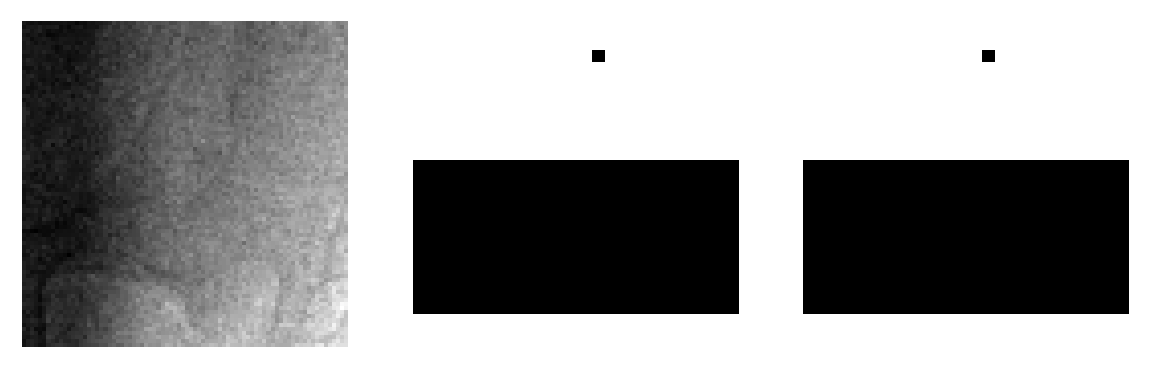

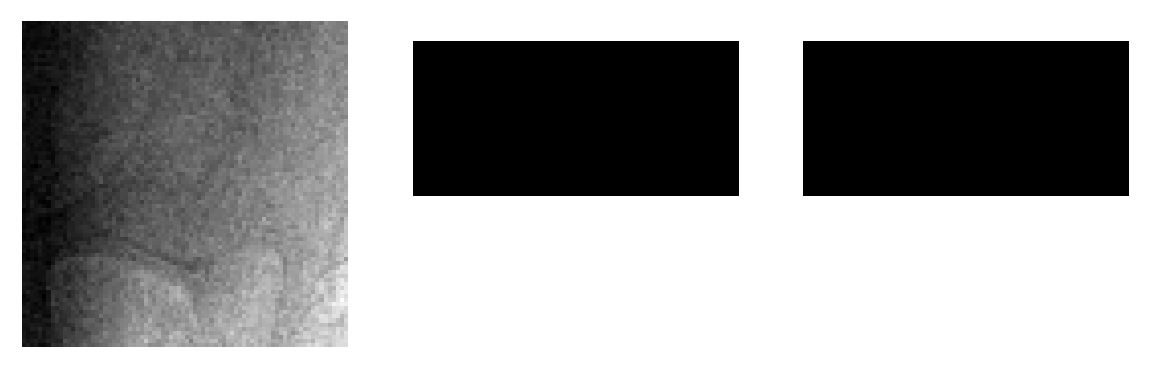

In [5]:
sg.refImages, sg.refNoises = sg.createReferences(testSet, 0)
sg.showMe(testSet, 0)

## <font style="color:lightblue">Models</font>

### <font style="color:lightblue">Generator</font>

In [9]:


class Generator(sg.GeneratorTemplate):

    def __init__(self):
        super(Generator, self).__init__(0)
        self.amplitude = 4

        self.noise2latent = self.createLatent()

        self.encoders =  nn.ModuleList([
            self.encblock( (4+self.latentChannels) /self.baseChannels,
                               1, 3, norm=False),
            self.encblock( 1,  1, 3, dopadding=True),
            self.encblock( 1,  2, 3, stride=2),
            self.encblock( 2,  2, 3, dopadding=True),
            self.encblock( 2,  4, 3, stride=2),
            self.encblock( 4,  4, 3, dopadding=True),
            self.encblock( 4,  8, 3, stride=2),
            self.encblock( 8,  8, 3, dopadding=True),
            self.encblock( 8, 16, 3, stride=2),
            self.encblock(16, 16, 3, dopadding=True),
            ])

        self.fcLink = self.createFClink()

        self.decoders = nn.ModuleList([
            self.decblock(32, 16, 3, dopadding=True),
            self.decblock(32,  8, 4, stride=2),
            self.decblock(16,  8, 3, dopadding=True),
            self.decblock(16,  4, 4, stride=2),
            self.decblock( 8,  4, 3, dopadding=True),
            self.decblock( 8,  2, 4, stride=2),
            self.decblock( 4,  2, 3, dopadding=True),
            self.decblock( 4,  1, 4, stride=2),
            self.decblock( 2,  1, 3, dopadding=True),
            self.decblock( 2,  1, 3, norm=False),
            ])

        self.lastTouch = self.createLastTouch()

        #sg.load_model(self, model_path="saves/gap16/noBNreNorm4/model_gen.pt" )



sg.generator = Generator().to(sg.TCfg.device)
sg.optimizer_G = sg.createOptimizer(sg.generator, sg.TCfg.learningRateG)
model_summary = summary(sg.generator, input_data=[ [sg.refImages[[0],0:4,...], sg.refNoises[[0],...]] ] ).__str__()
print(model_summary)




Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [1, 2, 80, 80]            --
├─ModuleList: 1-1                        --                        --
│    └─Sequential: 2-1                   [1, 64, 78, 78]           --
│    │    └─Conv2d: 3-1                  [1, 64, 78, 78]           2,368
│    │    └─LeakyReLU: 3-2               [1, 64, 78, 78]           --
│    └─Sequential: 2-2                   [1, 64, 78, 78]           --
│    │    └─Conv2d: 3-3                  [1, 64, 78, 78]           36,928
│    │    └─LeakyReLU: 3-4               [1, 64, 78, 78]           --
│    └─Sequential: 2-3                   [1, 128, 38, 38]          --
│    │    └─Conv2d: 3-5                  [1, 128, 38, 38]          73,856
│    │    └─LeakyReLU: 3-6               [1, 128, 38, 38]          --
│    └─Sequential: 2-4                   [1, 128, 38, 38]          --
│    │    └─Conv2d: 3-7                  [1, 128, 38, 38]          147,584

### <font style="color:lightblue">Discriminator</font>

In [ ]:

class Discriminator(sg.DiscriminatorTemplate):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.body =  nn.Sequential(
            self.encblock( 1/self.baseChannels,
                               1, 3, norm=False),
            self.encblock( 1,  1, 3, dopadding=True),
            self.encblock( 1,  2, 3, stride=2),
            self.encblock( 2,  2, 3, dopadding=True),
            self.encblock( 2,  4, 3, stride=2),
            self.encblock( 4,  4, 3, dopadding=True),
            self.encblock( 4,  8, 3, stride=2),
            self.encblock( 8,  8, 3, dopadding=True),
            self.encblock( 8, 16, 3, stride=2),
            self.encblock(16, 16, 3, dopadding=True),
            )
        self.head = self.createHead()
        #sg.load_model(self, model_path="/mnt/bctpro.data/anton/sinogap/saves/gap16/noBNreNorm_pureAdv/model_dis.pt" )


sg.discriminator = Discriminator()
sg.discriminator = sg.discriminator.to(sg.TCfg.device)
model_summary = summary(sg.discriminator, input_data=sg.refImages[0,...] ).__str__()
print(model_summary)
#sg.writer.add_graph(sg.discriminator, refImages)

sg.optimizer_D = sg.createOptimizer(sg.discriminator, sg.TCfg.learningRateD)



## <font style="color:lightblue">Restore checkpoint</font>

In [ ]:

sg.scheduler_G = None # torch.optim.lr_scheduler.StepLR(sg.optimizer_G, 1, gamma=1.001)
sg.scheduler_D = None
#sg.scheduler_D = torch.optim.lr_scheduler.StepLR(sg.optimizer_D, 1, gamma=0.999)
savedCheckPoint = f"checkPoint_{sg.TCfg.exec}"
sg.epoch, sg.imer, sg.minGEpoch, sg.minGdLoss, sg.startFrom, sg.resAcc = \
    sg.restoreCheckpoint(savedCheckPoint+".pth")
#sg.epoch, sg.imer, sg.minGEpoch, sg.minGdLoss, sg.startFrom = 0, 0, 0, 1, 0
sg.writer = sg.createWriter(sg.TCfg.logDir, True)
#sg.writer.add_graph(sg.generator, ((sg.refImages, sg.refNoises),) )
#sg.writer.add_graph(sg.discriminator, refImages)
sg.initialTest()

In [ ]:
#print("amplitude: ", sg.generator.amplitude.item(), 2 * torch.sigmoid(sg.generator.amplitude).item() )
#print(sg.epoch, sg.imer, sg.minGEpoch, sg.minGdLoss, sg.startFrom)
#lastLR = sg.scheduler_D.get_last_lr()[0]
#print(f"Initial LR : {lastLR:.6e}  {lastLR/sg.TCfg.learningRateD:.3f}")
#print(f"{sg.normRec.item():e}, {sg.normMSE.item():e}, {sg.normL1L.item():e}")
#print(f"{sg.normTestRec.item():e}, {sg.normTestMSE.item():e}, {sg.normTestL1L.item():e}")
#sg.freeGPUmem()
#sg.load_model(sg.generator, model_path="saves/gap16/noBNreNorm4/model_gen.pt" )
#sg.initialTest()
#lastLR = sg.scheduler_G.get_last_lr()[0]
#print(f"Initial LR : {lastLR:.6e}  {lastLR/sg.TCfg.learningRateG:.3f}")




## <font style="color:lightblue">Execute</font>

In [ ]:



sg.noAdv = False
sg.dataLoader = sg.createDataLoader(trainSet, num_workers=16)
sg.testLoader = sg.createDataLoader(testSet , num_workers=16)
#sg.scheduler_G = None
#sg.scheduler_D = None




#sg.normRec, sg.normMSE, sg.normL1L, _ , _ = sg.summarizeSet(sg.dataLoader)
#sg.normTestRec, sg.normTestMSE, sg.normTestL1L, _ , _ = sg.summarizeSet(sg.testLoader)
sg.normRec, sg.normMSE, sg.normL1L = 4.031e-03, 6.579e-03, 2.047e-02
sg.normTestRec, sg.normTestMSE, sg.normTestL1L = 4.868e-03, 1.382e-03, 1.369e-02
if sg.epoch == 0 :
    if sg.normRec == 1:
        sg.normRec, sg.normMSE, sg.normL1L, _ , _ = sg.summarizeSet(sg.dataLoader)
        sg.normTestRec, sg.normTestMSE, sg.normTestL1L, _ , _ = sg.summarizeSet(sg.testLoader)
    #sg.minGdLoss = sg.normTestRec
    #with torch.no_grad(): sg.generator.amplitude[()] = -math.log(1+2/sg.normMSE)

#torch.autograd.set_detect_anomaly(True)




#def my_afterEachEpoch(epoch) :
#    if sg.minGEpoch < 600 :
#        return
#    if not sg.dataLoader is None :
#        del sg.dataLoader
#        sg.freeGPUmem()
#    if sg.TCfg.batchSize < 131072 :
#    sg.TCfg.batchSize += round( 0.01 * sg.TCfg.batchSize )
#    sg.dataLoader = sg.createTrainLoader(trainSet, num_workers=24)
#    print("Batch size: ",sg.TCfg.batchSize)
#sg.afterEachEpoch = my_afterEachEpoch


#lastLR = sg.scheduler_G.get_last_lr()[0]
#print(f"Initial LR : {lastLR:.6e}  {lastLR/sg.TCfg.learningRateG:.3f}")
#def my_beforeReport() :
#    lastLR = sg.scheduler_G.get_last_lr()[0]
#    print(f"LR : {lastLR:.6e} {lastLR/sg.TCfg.learningRateG:.3f}")
#    if sg.scheduler_G.get_last_lr()[0]  >  5 * sg.TCfg.learningRateG :
#        return
#    if sg.scheduler_G is not None :
#        sg.scheduler_G.step()
#    if sg.scheduler_D is not None :
#        sg.scheduler_D.step()
#    return
#sg.beforeReport = my_beforeReport

sg.lossAdvCoef = 1.0
sg.lossDifCoef = 40

def my_beforeReport() :
    sg.lossDifCoef = min (sg.lossDifCoef * 1.001, 100.0)
    print(f"lossDifCoef: {sg.lossDifCoef}")
    with open(f"message_{sg.TCfg.exec}.txt", 'a') as file:
        file.write(f"lossDifCoef: {sg.lossDifCoef}\n")
sg.beforeReport = my_beforeReport

try :
    sg.train(savedCheckPoint)
except :
    del sg.dataLoader
    del sg.testLoader
    sg.freeGPUmem()
    1/10 # to release Jupyuter memory in the next step
    sg.epoch -= 1
    raise



## <font style="color:lightblue">Post</font>

In [ ]:
print (sg.generator.amplitude.item(), 2 * torch.sigmoid(sg.generator.amplitude).item() )
sg.initialTest()


In [ ]:
sg.testMe(trainSet, 5)

### <font style="color:lightblue">Save results</font>

In [ ]:
sg.saveModels()